The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Machine Translation and the Dataset
:label:`sec_machine_translation`

So far we see how to use recurrent neural networks for language models, in which we predict the next token given all previous tokens in an article. Now let us have a look at a different application, machine translation, whose predict output is no longer a single token, but a list of tokens. 

Machine translation (MT) refers to the automatic translation of a segment of text from one language to another. Solving this problem with neural networks is often called neural machine translation (NMT). Compared to language models (:numref:`sec_language_model`), in which the corpus only contains a single language, machine translation dataset has at least two languages, the source language and the target language. In addition, each sentence in the source language is mapped to the according translation in the target language. Therefore, the data preprocessing for machine translation data is different to the one for language models. This section is dedicated to demonstrate how to pre-process such a dataset and then load into a set of minibatches.


In [1]:
from d2l import torch as d2l
import torch
import os

## Reading and Preprocessing the Dataset

We first download a dataset that contains a set of English sentences with the corresponding French translations. As can be seen that each line contains an English sentence with its French translation, which are separated by a `TAB`.


In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[0:106])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !


We perform several preprocessing steps on the raw text data, including ignoring cases, replacing UTF-8 non-breaking space with space, and adding space between words and punctuation marks.


In [3]:
#@save
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !
fire !	au feu !


## Tokenization

Different to using character tokens in :numref:`sec_language_model`, here a token is either a word or a punctuation mark. The following function tokenizes the text data to return `source` and `target`. Each one is a list of token list, with `source[i]` is the $i^\mathrm{th}$ sentence in the source language and `target[i]` is the $i^\mathrm{th}$ sentence in the target language. To make the latter training faster, we sample the first `num_examples` sentences pairs.


In [4]:
#@save
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

We visualize the histogram of the number of tokens per sentence in the following figure. As can be seen, a sentence in average contains 5 tokens, and most of the sentences have less than 10 tokens.


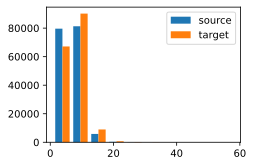

In [5]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
d2l.plt.legend(loc='upper right');

## Vocabulary

Since the tokens in the source language could be different to the ones in the target language, we need to build a vocabulary for each of them. Since we are using words instead of characters  as tokens, it makes the vocabulary size significantly large. Here we map every token that appears less than 3 times into the &lt;unk&gt; token :numref:`sec_text_preprocessing`. In addition, we need other special tokens such as padding and sentence beginnings.


In [6]:
src_vocab = d2l.Vocab(source, min_freq=3, 
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

9140

## Loading the Dataset

In language models, each example is a `num_steps` length sequence from the corpus, which may be a segment of a sentence, or span over multiple sentences. In machine translation, an example should contain a pair of source sentence and target sentence. These sentences might have different lengths, while we need same length examples to form a minibatch. 

One way to solve this problem is that if a sentence is longer than `num_steps`, we trim its length, otherwise pad with a special &lt;pad&gt; token to meet the length. Therefore we could transform any sentence to a fixed length.


In [7]:
#@save
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Trim
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

Now we can convert a list of sentences into an `(num_example, num_steps)` index array. We also record the length of each sentence without the padding tokens, called *valid length*, which might be used by some models. In addition, we add the special “&lt;bos&gt;” and “&lt;eos&gt;” tokens to the target sentences so that our model will know the signals for starting and ending predicting.


In [8]:
#@save
def build_array(lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if not is_source:
        lines = [[vocab['<bos>']] + l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(dim=1)
    return array, valid_len

Then we can construct minibatches based on these arrays. 

## Putting All Things Together

Finally, we define the function `load_data_nmt` to return the data iterator with the vocabularies for source language and target language.


In [9]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=1000):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3, 
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3, 
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(
        source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = build_array(
        target, tgt_vocab, num_steps, False)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return src_vocab, tgt_vocab, data_iter

Let us read the first batch.


In [10]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, num_steps=8)
for X, X_vlen, Y, Y_vlen in train_iter:
    print('X:', X.type(torch.int32))
    print('Valid lengths for X:', X_vlen)
    print('Y:', Y.type(torch.int32))
    print('Valid lengths for Y:', Y_vlen)
    break

X: tensor([[29, 11,  9,  4,  1,  1,  1,  1],
        [61, 41,  6,  1,  1,  1,  1,  1]], dtype=torch.int32)
Valid lengths for X: tensor([4, 3])
Y: tensor([[ 2, 56, 57,  5,  3,  1,  1,  1],
        [ 2, 73, 10,  0,  5,  3,  1,  1]], dtype=torch.int32)
Valid lengths for Y: tensor([5, 6])


## Summary

* Machine translation (MT) refers to the automatic translation of a segment of text from one language to another. 
* We read, preprocess, and tokenize the datasets from both source language and target language.


## Exercises

1. Find a machine translation dataset online and process it.


## [Discussions](https://discuss.mxnet.io/t/machine-translation/2396)

![](../img/qr_machine-translation-and-dataset.svg)
